setting up the data path ...


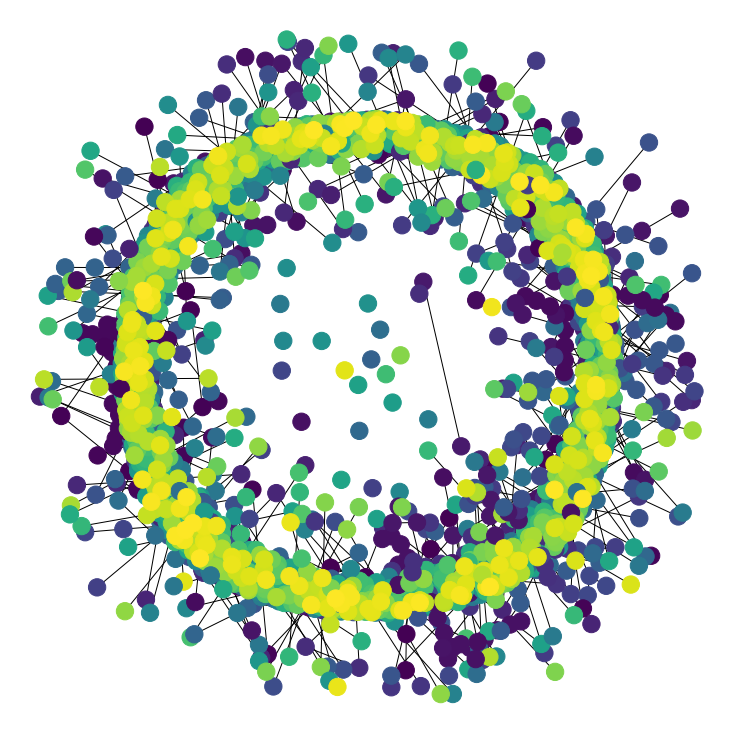

0.9902117187500082


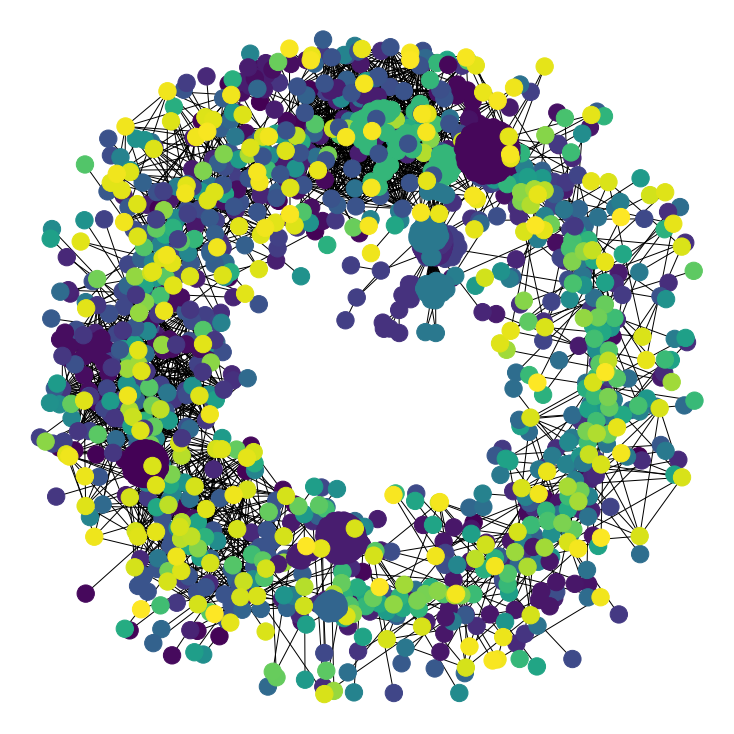

0.4105736370610655


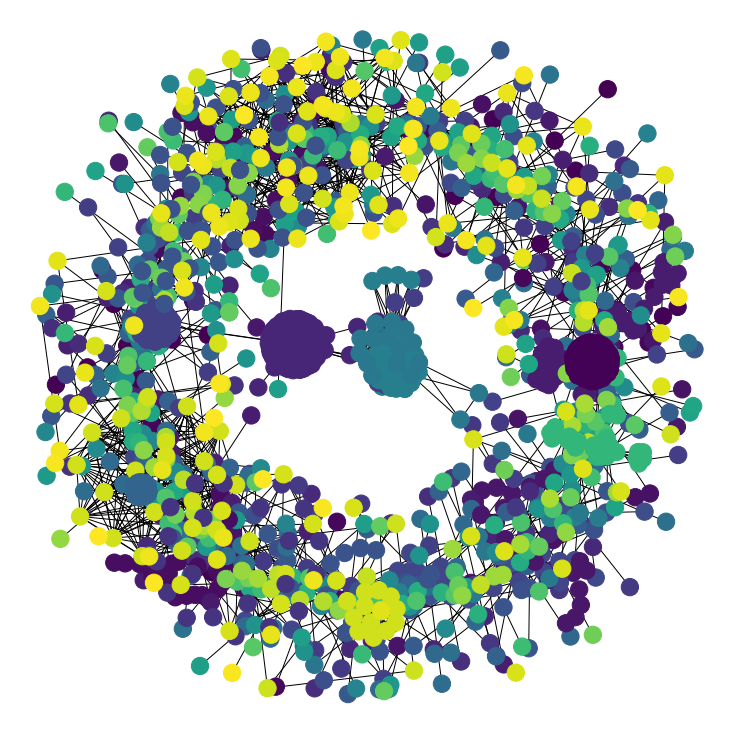

0.8982654352517627


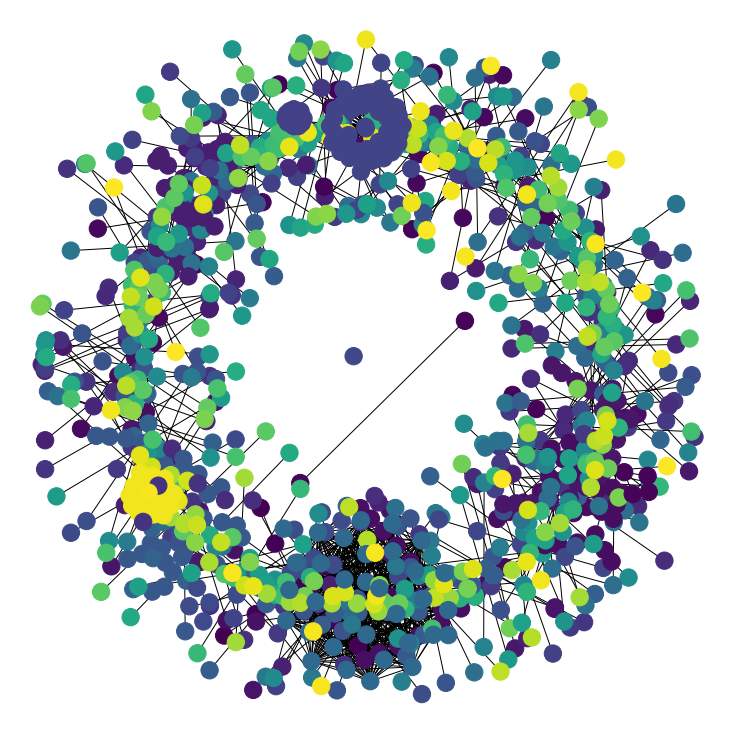

0.9062733220704842


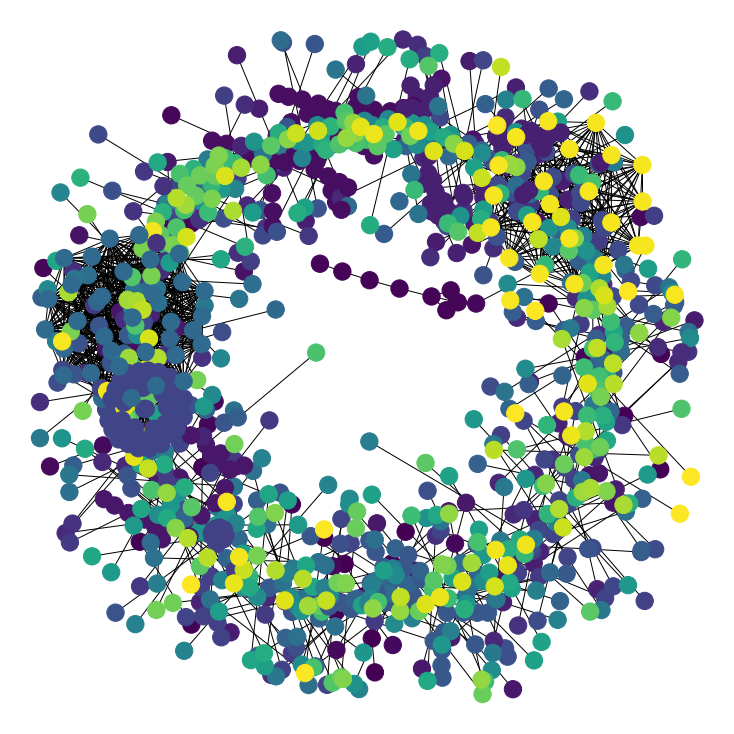

0.9054024690887517


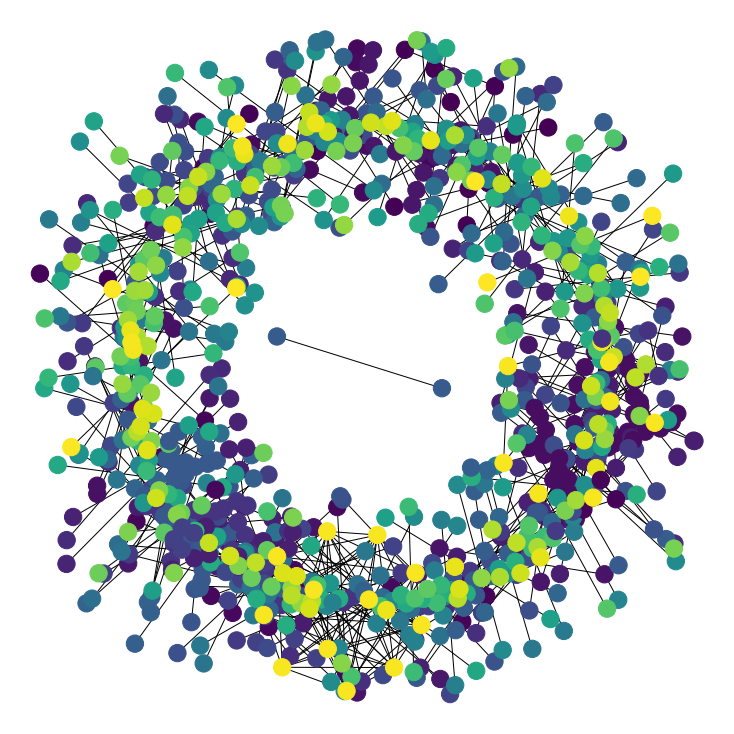

0.986235478550501


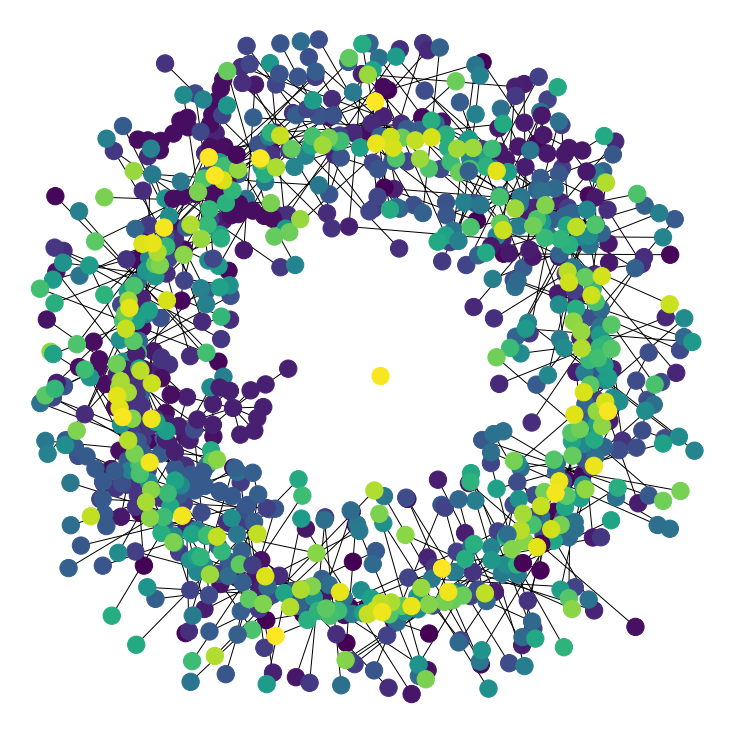

0.9902712086725197


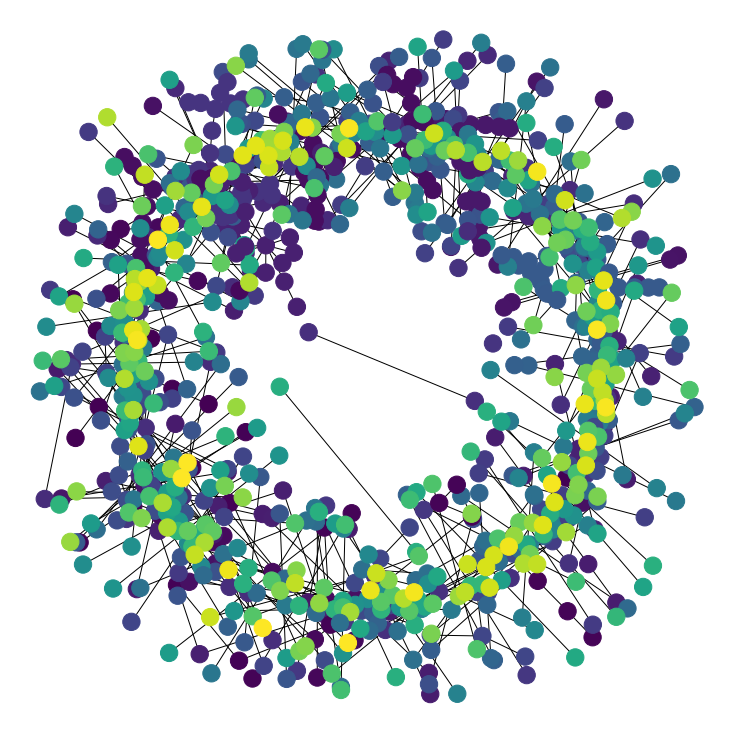

0.9902712086725197


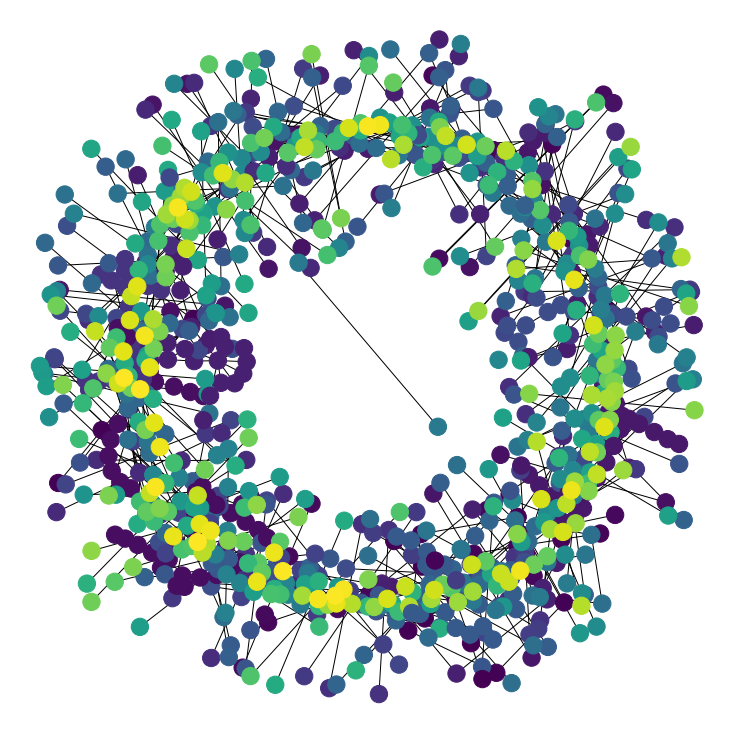

0.9902330264447958
done.


In [26]:
import os
import sys
import random

import json
import re

import collections
import pandas as pd
import numpy as np
import networkx as nx
#import ipycytoscape
#import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
from gensim.models import KeyedVectors
#from transformers import pipeline
import community as community_louvain

from pyvis.network import Network


###plotting graphs, figures, etc
def draw_graph_pyvis(nx_graph, name, title):
        """
        """
        nt = Network("1000px", "1000px", heading = title, notebook=False)
        nt.from_nx(nx_graph)
        #nt.show_buttons(filter_=['physics'])
        nt.save_graph(str(name) + "_nx.html")


def plots_graph_cytoscrap(G):
        """
        """
        model = ipycytoscape.CytoscapeWidget()
        model.graph.add_graph_from_networkx(G)
        display(model)


def plots_graph_hetero_edges(nodes, edge_list_A, colorA, edge_list, colorB, title, fig_name):
        # plot graph
        plt.figure(figsize=(10,10))
        plt.title(title)

        G = nx.cubical_graph()
        #pos = nx.spring_layout(G)
        pos = nx.random_layout(G)

        nx.draw_networkx_nodes(G, pos, nodelist=nodes, **options)

        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=edge_list_A,
            width=8,
            alpha=0.5,
            edge_color=colorA,
        )

        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=edge_list_B,
            width=.8,
            alpha=0.5,
            edge_color=colorB,
        )
        #plt.show()
        plt.savefig(fig_name, format="PNG")
        #plt.close()

def plots_graph(G, title, color, fig_name):
        # plot graph
        plt.figure(figsize=(10,10))
        plt.title(title)

        #pos = nx.spring_layout(G)
        pos = nx.random_layout(G)

        if color is None:
            nx.draw_networkx(G, with_labels=True,  pos = pos, node_size = 1, alpha = 0.6, width = 0.7)
        else:
            nx.draw_networkx(G, with_labels=True,  pos = pos, node_size = 1, 
                             alpha = 0.6, width = 0.7, edge_color=color)
            labels = nx.get_edge_attributes(G,'edge_weight')
            nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

        #plt.show()
        plt.savefig(fig_name, format="PNG")
        #plt.close()

    
def save_plot_dict_to_histo(data, title, labelX, labelY, labels, fig_name):
        degreeCount = collections.Counter(data.values())
        deg, cnt = zip(*degreeCount.items())

        _, ax = plt.subplots()

        plt.bar(deg, cnt, width=0.80, color="r")
        plt.title(title)
        plt.xlabel(labelX)
        plt.ylabel(labelY)

        ax.set_xticks([d for d in deg])
        ax.set_xticklabels(deg, rotation=90, ha='center')
        if labels is not None:
            ax.legend(labels)
        #plt.show(block=False)
        plt.savefig(fig_name, format="PNG")
        #plt.close()

        
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos


def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos


def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges


def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos
    

def draw_graph_and_community(G, partition):
        """
        """
        # draw the graph
        plt.figure(figsize=(10,10))
        #pos = nx.spring_layout(G)
        # color the nodes according to their partition
        #cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
        #nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
        #                       cmap=cmap, node_color=list(partition.values()))
        #nx.draw_networkx_edges(G, pos, alpha=0.5)
        
        pos = community_layout(G, partition)
        nx.draw(G, pos, node_color=list(partition.values()))
        plt.show()
   

def get_louvain_partition(G):
        """
        """
        # compute the best partition
        partition = community_louvain.best_partition(G)
        #f_in = open(os.path.join(results_dir, 'Louvain.txt'),'w')
        #for line in implementLouvain:
        #    f_in.write(str(line))
        #outputModularity_Louvain = graph.modularity(implementLouvain)
        #print("Modularity Optimal Value of louvain", outputModularity_Louvain)
        return partition
    
print ("setting up the data path ...")
data_dir = "/projets/sig/mullah/nlp/fgpi/"
figures_path ='../figures/'
graph_dir = "/projets/sig/mullah/nlp/fgpi/graph"
results_dir = "/projets/sig/mullah/nlp/fgpi/results"

#graph data path
explicit_graph_path = graph_dir + "/Graph_of_users_with_explicit_links"
explicit_graph = nx.read_gpickle(explicit_graph_path)
#explicit_graph.remove_nodes_from(list(nx.isolates(explicit_graph)))
partition = get_louvain_partition(explicit_graph) #apply community detection algorithm
draw_graph_and_community(explicit_graph, partition) #plots the communities

community_graph = community_louvain.induced_graph(partition, explicit_graph)
#nx.draw(community_graph)
print (community_louvain.modularity(partition, explicit_graph))

for step in range(1, 9):
    explicit_implicit_graph_path = graph_dir + "/Graph_of_users_with_explicit_and_implicit_links_" + str(step)
    explicit_implicit_graph = nx.read_gpickle(explicit_implicit_graph_path)
    #explicit_implicit_graph.remove_nodes_from(list(nx.isolates(explicit_implicit_graph)))
    partition = get_louvain_partition(explicit_implicit_graph) #apply community detection algorithm
    draw_graph_and_community(explicit_implicit_graph, partition) #plots the communities

    community_graph = community_louvain.induced_graph(partition, explicit_implicit_graph)
    #nx.draw(community_graph)
    print (community_louvain.modularity(partition, explicit_implicit_graph))

    
print ('done.')